# Continuous Control

---

In this project we will train an agent to play tennis.

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# Get the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print(brain_name)
print()
print(brain)

ReacherBrain

Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Get some more information about the environment.

In [4]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# Size of each action
action_size = brain.vector_action_space_size
print('\nSize of each action:', action_size)

# Examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('\nThere is 1 agent. It observes a state with length: {}'.format(states.shape[0], state_size))
print('\nThe state for the first agent looks like:\n', states[0])

Number of agents: 1

Size of each action: 4

There is 1 agent. It observes a state with length: 1

The state for the first agent looks like:
 [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

We take randome actions with the agent to see how it interacts with the environment.

In [5]:
def play(random=True):
    
    # Reset the environment
    env_info = env.reset(train_mode=True)[brain_name]     
    # Get the current state
    states = env_info.vector_observations                
    # Initialize the score to 0
    scores = np.zeros(num_agents)                          

    while True:
        if random:
            # Select a random action for the agent
            actions = np.random.randn(num_agents, action_size)
            # Clip the actions so that all actions are between -1 and 1
            actions = np.clip(actions, -1, 1)                
        else:
            # Select an action from making the agent act if random is not True
            actions = agent.act(states, add_noise=False)
        # Send actions to environment
        env_info = env.step(actions)[brain_name]           
        # Get the next state
        next_states = env_info.vector_observations         
        # Get the rewards
        rewards = env_info.rewards                        
        # Check if the episode has finished
        dones = env_info.local_done                        
        # Update the score
        scores += env_info.rewards                         
        # Roll over states to the next time step
        states = next_states                               
        # Exit loop if the episode has finished
        if np.any(dones):                                  
            break
    
    return round(np.mean(scores), 2)

In [6]:
score = play()
print('Total score: ', score)

Total score:  0.08


### 4. Use a neural network to train the agent 

In [7]:
import numpy as np
import random
import time
import torch

from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment

seed = 42

In [8]:
# Maximum number of training episodes
n_episodes = 2500
# Maximum number of timesteps per episode
max_t = 1000
# Interval to display results
print_every = 1

To train the agent we use an actor and a critic networks.

Both the actor and critic networks use 2 fully connected layers of depth 400 and 300. Batch normalization is applied to the input of the intermediate layer.

The hyper parameters used are the following:

* BUFFER_SIZE = int(2e5)  # replay buffer size
* BATCH_SIZE = 128        # minibatch size
* GAMMA = 0.999           # discount factor
* TAU = 2e-3              # for soft update of target parameters
* LR_ACTOR = 2e-4         # learning rate of the actor
* LR_CRITIC = 2e-4        # learning rate of the critic
* WEIGHT_DECAY = 0        # L2 weight decay


* LEARN_EVERY = 20        # learning timestep interval
* LEARN_NUM   = 10        # number of learning passes
* GRAD_CLIPPING = 1.0     # Gradient Clipping

* OU_SIGMA  = 0.15
* OU_THETA  = 0.05

* EPSILON       = 1.0     # for epsilon in the noise process (act step)
* EPSILON_DECAY = 1e-6

It took a lot of tuning and a lot of trials to settle on these parameters but overall with our defined architecture they were the ones that allowed us to reach convergence sooner.

In [9]:
# We use a Deep Deterministic Policy Gradient (DDPG) architecture to train the agent

def train(n_episodes=n_episodes, max_t=max_t, print_every=print_every):
    
    # List of mean scores from each episode
    mean_scores = []                               
    # List of moving averages
    moving_avgs = []                               
    best_score  = -np.inf
    # Mean scores from most recent 100 episodes
    scores_window = deque(maxlen=100)             
    
    for i_episode in range(1, n_episodes+1):
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name]     
        # Get current state for each agent
        states = env_info.vector_observations                   
        # Initialize score for each agent
        scores = np.zeros(num_agents) 
        
        agent.reset()
        
        start_time = time.time()
        
        for t in range(max_t):
            # Select an action
            actions = agent.act(states, add_noise=True)        
            # Send actions to environment
            env_info = env.step(actions)[brain_name]            
            # Get next state
            next_states = env_info.vector_observations          
            # Get reward
            rewards = env_info.rewards                         
            # Check if the episode has finished
            dones = env_info.local_done                       
            # Save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)   
            # Update the state and the scores
            states, scores = next_states, scores+rewards
            # Exit loop if the episode has ended
            if np.any(dones):                                 
                break

        duration = time.time() - start_time
        # Save the mean score for the episode
        mean_scores.append(np.mean(scores))           
        # Save the mean score to the window
        scores_window.append(mean_scores[-1])         
        # Save the moving average
        moving_avgs.append(np.mean(scores_window))    
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({}s)\tMean: {:.1f}\tMoving Avg: {:.1f}'.format(\
                  i_episode, round(duration), mean_scores[-1], moving_avgs[-1]))
                  
        if moving_avgs[-1] >= 30.00 and i_episode >= 100:
            # If the environment has been solved, save the weights of the actor and the critic
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, moving_avgs[-1]))            
            break
            
    return mean_scores, moving_avgs

Train the network.

In [10]:
start = time.time()

# Define the agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)

# Train the agent
scores, avgs = train()

end = time.time()
elapsed = end - start

print('\nTime Elapsed: {}min {:.2f}sec'.format(elapsed//60, elapsed%60))

Episode 1 (8s)	Mean: 0.1	Moving Avg: 0.1
Episode 2 (9s)	Mean: 0.3	Moving Avg: 0.2
Episode 3 (9s)	Mean: 0.4	Moving Avg: 0.3
Episode 4 (9s)	Mean: 0.2	Moving Avg: 0.3
Episode 5 (9s)	Mean: 0.8	Moving Avg: 0.4
Episode 6 (9s)	Mean: 0.6	Moving Avg: 0.4
Episode 7 (9s)	Mean: 0.1	Moving Avg: 0.4
Episode 8 (9s)	Mean: 0.4	Moving Avg: 0.4
Episode 9 (9s)	Mean: 0.2	Moving Avg: 0.4
Episode 10 (9s)	Mean: 2.3	Moving Avg: 0.6
Episode 11 (9s)	Mean: 1.9	Moving Avg: 0.7
Episode 12 (9s)	Mean: 0.8	Moving Avg: 0.7
Episode 13 (9s)	Mean: 0.6	Moving Avg: 0.7
Episode 14 (9s)	Mean: 1.1	Moving Avg: 0.7
Episode 15 (9s)	Mean: 3.6	Moving Avg: 0.9
Episode 16 (9s)	Mean: 0.7	Moving Avg: 0.9
Episode 17 (9s)	Mean: 1.0	Moving Avg: 0.9
Episode 18 (9s)	Mean: 1.1	Moving Avg: 0.9
Episode 19 (9s)	Mean: 2.0	Moving Avg: 1.0
Episode 20 (9s)	Mean: 1.8	Moving Avg: 1.0
Episode 21 (9s)	Mean: 1.3	Moving Avg: 1.0
Episode 22 (9s)	Mean: 0.9	Moving Avg: 1.0
Episode 23 (9s)	Mean: 2.6	Moving Avg: 1.1
Episode 24 (9s)	Mean: 0.9	Moving Avg: 1.1
E

Plot the scores.

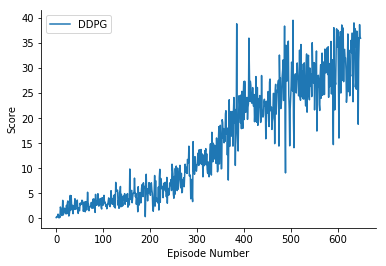

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the scores
fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores, label='DDPG')
ax.set_ylabel('Score')
ax.set_xlabel('Episode Number')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='upper left');
plt.show()

Play the game randomly and following the policy a few times to see the difference in how well the agent performs.

In [12]:
num_trials = 3

for trial in range(num_trials):
    print('Trial Num ', trial+1)
    score = play(random=True)
    print('Playing randomly score: ', score)
    score = play(random=False)
    print('Playing following the policy score: ', score)
    print()

Trial Num  1
Playing randomly score:  0.24
Playing following the policy score:  21.51

Trial Num  2
Playing randomly score:  0.23
Playing following the policy score:  23.57

Trial Num  3
Playing randomly score:  0.0
Playing following the policy score:  32.27



### 5. Ideas for improvements

To possibly improve these results, we could:
1. Try using other architecture like PPO, A3C or D4PG
2. Fine tuning the hyper parameters some more to get a faster convergence